In [2]:
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from datasets import load_dataset

In [3]:
# Load the SWDA dataset
swda = load_dataset("swda")

swda = swda.remove_columns(['swda_filename', 'ptb_basename', 'transcript_index', 'act_tag', 'caller', 'utterance_index', 'subutterance_index', 'pos', 'trees', 'ptb_treenumbers', 'talk_day', 'length', 'topic_description', 'prompt', 'from_caller', 'from_caller_sex', 'from_caller_education', 'from_caller_birth_year', 'from_caller_dialect_area', 'to_caller', 'to_caller_sex', 'to_caller_education', 'to_caller_birth_year', 'to_caller_dialect_area'])
swda = swda.rename_column("damsl_act_tag", "label")
swda


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/213543 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/56729 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4514 [00:00<?, ? examples/s]

Dataset swda downloaded and prepared to /root/.cache/huggingface/datasets/swda/default/0.0.0/b53d17ec4c6e31d0921591dd2d8e86d15850822209a980fcddb2983fc948e499. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['conversation_no', 'label', 'text'],
        num_rows: 213543
    })
    validation: Dataset({
        features: ['conversation_no', 'label', 'text'],
        num_rows: 56729
    })
    test: Dataset({
        features: ['conversation_no', 'label', 'text'],
        num_rows: 4514
    })
})

In [4]:
import re 

def clean_swda_utterance(text):
    text = re.sub(r'\[.*?\]', '', text)
    text = text.strip()
    text = re.sub(r'\(.*?\)', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.lower()
    text = ' '.join(text.split())
    return {"text": text}

In [5]:
swda = swda.map(lambda x : clean_swda_utterance(x['text']))

  0%|          | 0/213543 [00:00<?, ?ex/s]

  0%|          | 0/56729 [00:00<?, ?ex/s]

  0%|          | 0/4514 [00:00<?, ?ex/s]

In [6]:
# Tokenize the input and context
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
swda = swda.map(lambda x: tokenizer(x['text'], padding='max_length', truncation=True), batched=True)

  0%|          | 0/214 [00:00<?, ?ba/s]

  0%|          | 0/57 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

In [7]:
import torch
from torch.utils.data import DataLoader, Dataset


class SWDADataset(Dataset):
    def __init__(self, swda, tokenizer, max_seq_length):
        self.swda = swda
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.swda)

    def __getitem__(self, index):
        # Get input text
        input_text = self.tokenizer.encode_plus(
            self.swda[index]['text'],
            add_special_tokens=True,
            max_length=self.max_seq_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Get context
        # Get context n-1
        if index > 0 and self.swda[index]['conversation_no'] == self.swda[index-1]['conversation_no']:
            context = self.swda[index-1]
        else:
            context = self.swda[index]
        context = self.tokenizer.encode_plus(
            context['text'],
            add_special_tokens=True,
            max_length=self.max_seq_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Get label
        label = self.swda[index]['label']
        
        return input_text, context, label

In [8]:
# Create the train loader
train_dataset = SWDADataset(swda['train'], tokenizer, max_seq_length=128)
val_dataset = SWDADataset(swda['validation'], tokenizer, max_seq_length=128)
test_dataset = SWDADataset(swda['test'], tokenizer, max_seq_length=128)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# Define the model architecture
# Define model architecture
class RNN(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(RNN, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        for param in self.bert.parameters():
            param.requires_grad = False
        self.rnn = nn.GRU(input_size=768, hidden_size=hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, input_text, context):
        input_ids = input_text['input_ids'].to(device)
        attention_mask = input_text['attention_mask'].to(device)
        context_ids = context['input_ids'].to(device)
        context_mask = context['attention_mask'].to(device)
        
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        pooled_output = outputs.pooler_output

        context_outputs = self.bert(input_ids=context_ids, attention_mask=context_mask, return_dict=True)
        pooled_context_output = context_outputs.pooler_output
        
        
        output, _ = self.rnn(pooled_output.unsqueeze(1))
        context_output, _ = self.rnn(pooled_context_output.unsqueeze(1))
        output = self.fc1(output)
        output = torch.cat((output.squeeze(1), context_output.squeeze(1)), dim=1)
        output = self.fc2(output)
        return output

# Instantiate the model
# Instantiate model and move it to device
model = RNN(hidden_size=256, num_classes=43)
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [13]:
train_losses = []
val_losses = []


train_accuracies = [] 
val_accuracies = []

num_epochs = 5

best_val_loss = float('inf')
for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for i, (input_text, context, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        input_text = {
            'input_ids': input_text['input_ids'].squeeze(1),
            'attention_mask': input_text['attention_mask'].squeeze(1),
            'token_type_ids': input_text['token_type_ids'].squeeze(1)
        }
        context = {
            'input_ids': context['input_ids'].squeeze(1),
            'attention_mask': context['attention_mask'].squeeze(1),
            'token_type_ids': context['token_type_ids'].squeeze(1)
        }
        labels = labels.to(device)
        output = model(input_text, context)
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * input_text["input_ids"].size(0)

        # Compute accuracy for this batch
        predicted_labels = output.argmax(dim=1)
        num_correct = (predicted_labels == labels).sum().item()
        acc = num_correct / len(labels)
        epoch_acc += acc
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}')

    # Compute average loss and accuracy for epoch
    epoch_loss /= len(train_loader)
    epoch_acc /= len(train_loader)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    
    # Validation loop
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for input_text, context, labels in val_loader:
            input_text = {
                'input_ids': input_text['input_ids'].squeeze(1),
                'attention_mask': input_text['attention_mask'].squeeze(1),
                'token_type_ids': input_text['token_type_ids'].squeeze(1)
            }
            context = {
                'input_ids': context['input_ids'].squeeze(1),
                'attention_mask': context['attention_mask'].squeeze(1),
                'token_type_ids': context['token_type_ids'].squeeze(1)
            }
            labels = labels.to(device)
            output = model(input_text, context)
            loss = criterion(output, labels)

            val_loss += loss.item() * input_text["input_ids"].size(0)

            # Compute accuracy for this batch
            predicted_labels = output.argmax(dim=1)
            num_correct = (predicted_labels == labels).sum().item()
            acc = num_correct / len(labels)
            val_acc += acc
            
    # Compute average validation loss and accuracy
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_acc /= len(val_loader)
    val_accuracies.append(val_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')


Epoch [1/5], Step [100/1669], Train Loss: 1.7519
Epoch [1/5], Step [200/1669], Train Loss: 1.4382
Epoch [1/5], Step [300/1669], Train Loss: 1.4524
Epoch [1/5], Step [400/1669], Train Loss: 1.5077
Epoch [1/5], Step [500/1669], Train Loss: 1.4591
Epoch [1/5], Step [600/1669], Train Loss: 1.2450
Epoch [1/5], Step [700/1669], Train Loss: 1.2766
Epoch [1/5], Step [800/1669], Train Loss: 1.4281
Epoch [1/5], Step [900/1669], Train Loss: 1.2698
Epoch [1/5], Step [1000/1669], Train Loss: 1.3243
Epoch [1/5], Step [1100/1669], Train Loss: 1.0697
Epoch [1/5], Step [1200/1669], Train Loss: 1.2856
Epoch [1/5], Step [1300/1669], Train Loss: 1.1153
Epoch [1/5], Step [1400/1669], Train Loss: 1.3020
Epoch [1/5], Step [1500/1669], Train Loss: 1.2059
Epoch [1/5], Step [1600/1669], Train Loss: 1.4192
Epoch 1/5, Loss: 182.3750, Accuracy: 0.5686
Epoch 1/5, Val Loss: 78.0496, Val Accuracy: 0.6138
Epoch [2/5], Step [100/1669], Train Loss: 1.3419
Epoch [2/5], Step [200/1669], Train Loss: 1.3455
Epoch [2/5], Ste

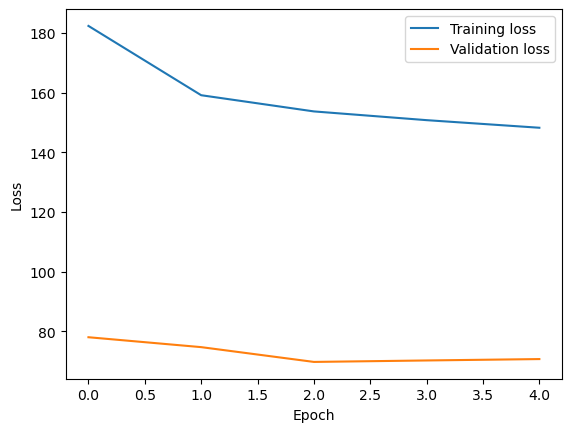

In [14]:
import matplotlib.pyplot as plt


# Plot training and validation loss
plt.figure()
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

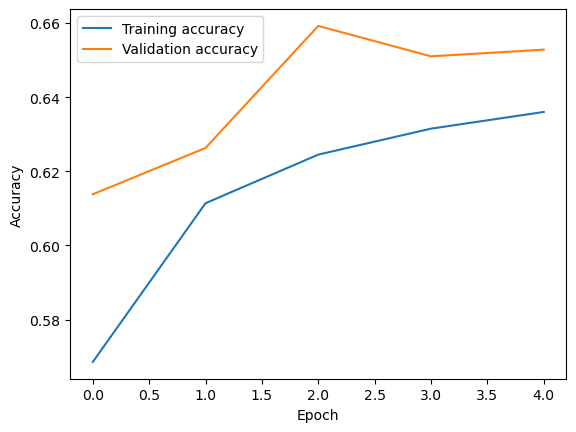

In [19]:
# Plot training and validation accuracy
plt.figure()
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model_state_dict = torch.load("bert_gru_context.pt", map_location=torch.device('cpu'))
model.load_state_dict(model_state_dict)

In [16]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

model.eval()
all_true_labels = []
all_predicted_labels = []
with torch.no_grad():
    for input_text, context, labels in test_loader:
        input_text = {
            'input_ids': input_text['input_ids'].squeeze(1),
            'attention_mask': input_text['attention_mask'].squeeze(1),
            'token_type_ids': input_text['token_type_ids'].squeeze(1)
        }
        context = {
            'input_ids': context['input_ids'].squeeze(1),
            'attention_mask': context['attention_mask'].squeeze(1),
            'token_type_ids': context['token_type_ids'].squeeze(1)
        }
        labels = labels.to(device)
        output = model(input_text, context)

        # Store true and predicted labels for this batch
        predicted_labels = output.argmax(dim=1)
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted_labels.cpu().numpy())

# Calculate precision, recall, F1-score, and support
precision, recall, f1_score, support = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted', zero_division=0)

# Create a DataFrame with the metrics
metrics_data = {
    'Weighted Avg Precision': [precision],
    'Weighted Avg Recall': [recall],
    'Weighted Avg F1-score': [f1_score],
}


metrics_df = pd.DataFrame(metrics_data)

# Display the metrics DataFrame
print(metrics_df)


   Weighted Avg Precision  Weighted Avg Recall  Weighted Avg F1-score
0                0.631686             0.630483               0.593067


In [17]:
model.eval()
test_loss = 0
test_acc = 0
with torch.no_grad():
    for input_text, context, labels in test_loader:
        input_text = {
            'input_ids': input_text['input_ids'].squeeze(1),
            'attention_mask': input_text['attention_mask'].squeeze(1),
            'token_type_ids': input_text['token_type_ids'].squeeze(1)
        }
        context = {
            'input_ids': context['input_ids'].squeeze(1),
            'attention_mask': context['attention_mask'].squeeze(1),
            'token_type_ids': context['token_type_ids'].squeeze(1)
        }
        labels = labels.to(device)
        output = model(input_text, context)
        loss = criterion(output, labels)

        test_loss += loss.item() * input_text["input_ids"].size(0)

        # Compute accuracy for this batch
        predicted_labels = output.argmax(dim=1)
        num_correct = (predicted_labels == labels).sum().item()
        acc = num_correct / len(labels)
        test_acc += acc

# Compute average test loss and accuracy
test_loss /= len(test_loader)
test_acc /= len(test_loader)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')


Test Loss: 72.5206, Test Accuracy: 0.6302
